Recommendation systems week06 - Item based Collaborative Filtering
====

# Why?

User user CF is great, but
* when data is sparse we cant group data, find connections ect
* data computation
	* it becomes very CPU heavy
	* you cant compute it efficiently
		* most matrixes cant be pre-computed
		* it changes too much
* if users >> items
	* relationship between items is stable
	* a lot of rankings from users
	* items do not change too much - stability
	* they still personalise to individual preferences
* [check his paper for more information](http://recsys.cs.umn.edu/docs/Item-Based-WWW-2001.pdf)
* product association
	* this is not the same as I-I, it was before
	* use transactions, browse sections ect for ratings

## How we do it?

* compute similarity between pairs of items
	* cosine of items, normalised by each user rating
		* only for values we have for both
	* some user conditional probability (unary)
* predict user-item rating
	* weighted sum
	* linear regression
	* [top N items](http://glaros.dtc.umn.edu/gkhome/node/127)

## Does it work?

* efficient
* broad application and flexibility

## shortcomings

* some relationship can't be stable
* lower serendipity
	* need to surprise user as well


# How we do it

* calculate item similarity
	* [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $sim(i,j)=cos(\theta)=\frac{A \cdot B}{\left\Vert A \right\Vert \left\Vert B \right\Vert}$
	* recent experiment show that using normalised rankings increase prediction accuracy.
* score the items to find items similiar to ones liked by user
	* $p_{ui}=\frac{\sum_{j \in N} sim(i,j)r_{uj}}{\sum_{j \in N}|sim(i,j)|}$
* create porediction
	* for ex k=20 is:
		* take user i
		* look at 20 movies that are most similiar to item j we are looking at and have been rated by user i
		* use weighted average of user i rankings for them as preduction for new movie
L2 norm (Euclidean length, or square root of sum of squares)

## advantages

* we can pre-compute similarities, and those remain stable - we dont need to recompute them
* it should be $O(|items|)^2$
	* in reality we need to compute only one directions
	* can skip items of no interest
		* we can truncate model as long as we got enough neighbours to calculate score
		* need M >> k neighbours per item in model
	* it can be more efficient this way
* we can tweak it
	* model size
	* no of neighbours

## disadvantage

* coverage of item-item filtering tends to be worse than user-user one

# urinary data

* what we do with NaNs?
* data normalisation
	* mean-centring is not meaningful
	* normalise user vectors to unit vectors
		* users who like many items provide less information about this particular one
		* more selective user provide more information
		* we can also log() values instead normalising
* conditional probability
	* $sim(i,j) = P(j | i) = \frac{P(i,j)}{P(i)} = \frac{P(i,j)}{P(i)} = \frac{\frac{|u(i) \cap u(j)|}{n}}{\frac{|u(i)|}{n}} = \frac{|u(i) \cap u(j)|}{|u(i)|}$
	* to make it more behaved let dampen it frequency effect by rewriting equation to $\frac{P(i,j)}{P(i)P(j)^{\alpha}}$ where $0<\alpha <1$
	* it will still provide us with value in {-1;1}
* weighted average is not meaningful for binary
* we sum neighbours similarities
	* $\textrm{score}(u,i) =  \sum_{j \in N} sim(i,j)$

# hybrids

We can combined multiple algorithms - this is the most common approach used today

* we can use weights and assemble models
* we can switch between algorithms
* we can mix outputs from algorithms
* we can use output from one algorithm as input to another one
* [see this book for more information](http://link.springer.com/article/10.1023%2FA%3A1021240730564)
* [and this for paper on the subject](http://md.ekstrandom.net/research/pubs/auto-reading-lists/)
* Netflix winner have been a liner combination of several predictors
	* sort each predictor input as linear equation $p(u,i) =  a_1p_1(u,i)+ a_2p_2(u,i) + ... + a_n p_n(u,i) + b$
	* use LSA to calculate weights for combined prediction
* combine with [user reputation](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.59.5213&rep=rep1&type=pdf)
	* weight users by trust before computing item similarities
* combine with page ranking for research papers
	* use it for paper citations using page rank like logic
	* treat web pages that page links to as recommendations
* combine item-item algorithm with content based similarities
	* this is  not collaborative filter
	* use similarities as weights
	* infer coefficients from the data
		* minimise RMSE
		* gradient descend


# Item-Item vs User-User

* ppl are having complex taste
	* User-User can detect this
	* I-I can't
* this is why I-I work well on main stream but can't surprise and delight


# interviews

## Brad Miller: practical issues

* increase throughput
* decrease latency (100 -- 200 msec)
* item-item allowed to improve algorithm
	* mostly as you could do calculation off-line
	* quality of recommendations seem to be the same
	* algorithm noticed both positive and negative correlations


## Robin Bruke: Introduction to Hybrid Recommendation Systems

* combine strengths of systems
* different types
	* black box - weighed
	* mixing recommended list by mixing different lists (for ex 60:40 )
	* switching algorithm - we can turn certain algorithms off
	* cascades algorithms - use output of one algorithm as input to other one or limit the other one based on the prior one
	* feature combinations/augmentation
	* meta hybrid - use one algorithm to create user profile and other one to recommend based on the profile
* downside
	* additional computation cost
	* extra work is needed
* they are widely used


# Assignment 5 Instructions: Item Based

Your core task is to compute item similarities using:

* Cosine similarity between items using raw (unnormalized) ratings.
* Cosine similarity using adjusted (normalized) ratings.


## Read File
Again, I extracted data from Excel file provided and run functions in python. 

In [1]:
from __future__ import division #so I can have float as std and int as //
import pandas as pd
import pylab
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import copy

import pdb #debugger
%matplotlib inline

#my own functions
from supportFunctions import * #you CAN'T RELOAD functions

C:\Users\LKB\Anaconda\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
dataFile = "Assignment5.csv"
print("reading %s" % dataFile)
dfData = pd.read_csv(dataFile, delimiter = ";", error_bad_lines=True, encoding = 'utf-8-sig',na_values = ["NULL",""]\
                     ,header =0,index_col=0);
dfData.head(3)

reading Assignment5.csv


,1: Toy Story (1995),1210: Star Wars: Episode VI - Return of the Jedi (1983),356: Forrest Gump (1994),"318: Shawshank Redemption, The (1994)","593: Silence of the Lambs, The (1991)",3578: Gladiator (2000),260: Star Wars: Episode IV - A New Hope (1977),2028: Saving Private Ryan (1998),296: Pulp Fiction (1994),1259: Stand by Me (1986),2396: Shakespeare in Love (1998),2916: Total Recall (1990),780: Independence Day (ID4) (1996),541: Blade Runner (1982),1265: Groundhog Day (1993),"2571: Matrix, The (1999)",527: Schindler's List (1993),"2762: Sixth Sense, The (1999)",1198: Raiders of the Lost Ark (1981),34: Babe (1995)
755,2,5,2,NaN,4,4,1,2,NaN,3,2,NaN,5,2,5,4,2,5,NaN,NaN
5277,1,NaN,NaN,2,4,2,5,NaN,NaN,4,3,2,2,NaN,2,NaN,5,1,3,NaN
1577,NaN,NaN,NaN,5,2,NaN,NaN,NaN,NaN,1,NaN,1,4,4,1,1,2,3,1,3


## Preparing data

Spreadsheet provides us with additional information, which we will calculate below

* mean user votes for each user
* eucledian L2 norm - $\sqrt{\sum x^2}$
* normalised data, which is orginal dataset minus user mean values
    * order of operation is critical here, we mean excluding NaNs then replace NaNs with 0

In [3]:
Usermean = dfData.mean(axis=1,skipna=True)
L2norm = np.sqrt(np.square(dfData.transpose()).sum(axis=1))

dfAdjusted = dfData.sub(dfData.mean(axis=1,skipna=True), axis=0).fillna(0)
dfAdjusted.head(3)

,1: Toy Story (1995),1210: Star Wars: Episode VI - Return of the Jedi (1983),356: Forrest Gump (1994),"318: Shawshank Redemption, The (1994)","593: Silence of the Lambs, The (1991)",3578: Gladiator (2000),260: Star Wars: Episode IV - A New Hope (1977),2028: Saving Private Ryan (1998),296: Pulp Fiction (1994),1259: Stand by Me (1986),2396: Shakespeare in Love (1998),2916: Total Recall (1990),780: Independence Day (ID4) (1996),541: Blade Runner (1982),1265: Groundhog Day (1993),"2571: Matrix, The (1999)",527: Schindler's List (1993),"2762: Sixth Sense, The (1999)",1198: Raiders of the Lost Ark (1981),34: Babe (1995)
755,-1.200000,1.8,-1.2,0.000000,0.800000,0.800000,-2.200000,-1.2,0,-0.200000,-1.200000,0.000000,1.800000,-1.200000,1.800000,0.800000,-1.200000,1.800000,0.000000,0.000000
5277,-1.769231,0.0,0.0,-0.769231,1.230769,-0.769231,2.230769,0.0,0,1.230769,0.230769,-0.769231,-0.769231,0.000000,-0.769231,0.000000,2.230769,-1.769231,0.230769,0.000000
1577,0.000000,0.0,0.0,2.666667,-0.333333,0.000000,0.000000,0.0,0,-1.333333,0.000000,-1.333333,1.666667,1.666667,-1.333333,-1.333333,-0.333333,0.666667,-1.333333,0.666667


## Similarity Functions

We will use cosine similarity  $sim(i,j)=cos(\theta)=\frac{A \cdot B}{\left\Vert A \right\Vert \left\Vert B \right\Vert}$ to determine similarities between items (moves). The denominator is combination of the relevant euclidean L2 norms while numerator is  an inner product between each pair of columns. The best function to use here is NumPy's einsum - [*"Generally speaking, use Pandas when you need alignment or grouping by index, use NumPy when doing computation on N-dimensional arrays"*](http://stackoverflow.com/questions/27733482/pandas-rolling-correlation-with-fixed-patch-for-pattern-matching). It is a bit complex to use so head to [this post](http://ajcr.net/Basic-guide-to-einsum/) for explanation.


It is worth nothing that:

* pandas offer [spearman correlation coefficient](http://pandas.pydata.org/pandas-docs/stable/computation.html#correlation);
* scilearn offer a lot of pairwise correlation tools - check out [*sklearn.metrics.pairwise.pairwise_distances*](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_distances.html), just remember to covert distances to correlation.

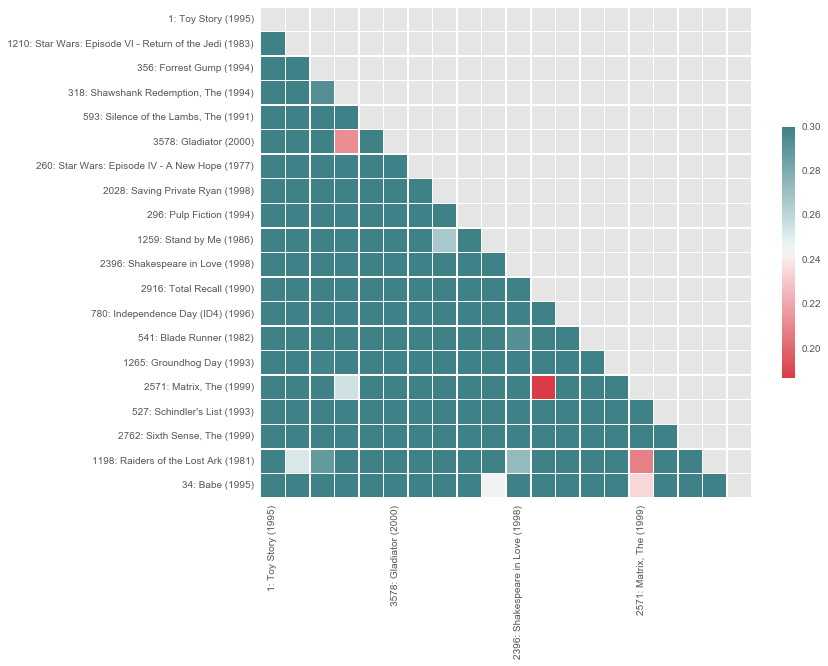

In [4]:
# get inner prodict of all columns in nice corr matrix
dataArray = dfData.fillna(0).values.astype('int') #for numpy
numerator = np.einsum('ij,ik', dataArray, dataArray)
#convert euclidean L2 norms to matrix
L2norm = np.sqrt(np.square(dfData.transpose()).sum(axis=1))
denominator = np.einsum('i,j', L2norm, L2norm)

#get our corr matrix -> sim(i,j)
corrMatrix = pd.DataFrame(numerator/denominator,columns=dfData.columns, index=dfData.columns)
MakeNiceCorrPlot(corrMatrix)

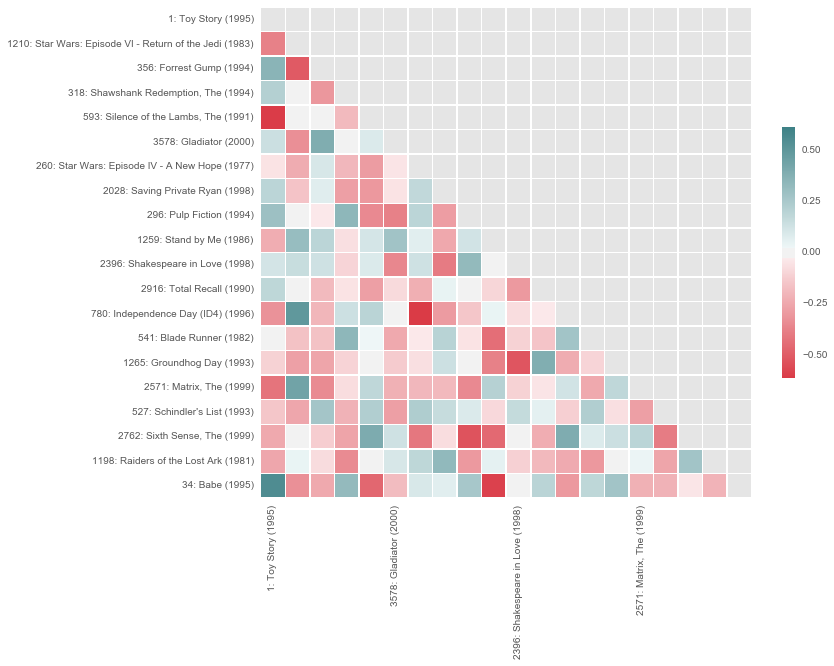

In [5]:
corrMatrixAdjusted = getCosineCorrMatrix(dfAdjusted)

## Deliverables

* Provide 5 movies most similar to Toy Story, in decreasing order of similarity. Only provide the movie ID.
* Provide the top 5 recommended movies for user 5277, using an average of the user’s ratings weighted by similarity to each candidate movie. You do not need to exclude movies they have rated. Consider all movies with **nonnegative similarities** (do not limit neighborhood size). 

For each submit both unnormalized and normalized results.

### Provide 5 movies most similar to Toy Story

In [6]:
GetTopFive(corrMatrix.ix['1: Toy Story (1995)',:])

260: Star Wars: Episode IV - A New Hope (1977)    0.747
780: Independence Day (ID4) (1996)                0.691
296: Pulp Fiction (1994)                          0.668
318: Shawshank Redemption, The (1994)             0.667
1265: Groundhog Day (1993)                        0.661
Name: 1: Toy Story (1995), dtype: float64

In [7]:
GetTopFive(corrMatrixAdjusted.ix['1: Toy Story (1995)',:])

34: Babe (1995)                          0.554
356: Forrest Gump (1994)                 0.356
296: Pulp Fiction (1994)                 0.295
318: Shawshank Redemption, The (1994)    0.216
2028: Saving Private Ryan (1998)         0.193
Name: 1: Toy Story (1995), dtype: float64

### Provide the top 5 recommended movies

In [8]:
userRatedMovies = dfData.loc[[5277]] #find user '755' (index 755)
predictions = ItemBasedPrediction(userRatedMovies,corrMatrix)
GetTopFivePredictions(predictions)

527: Schindler's List (1993)                      2.974
1259: Stand by Me (1986)                          2.929
260: Star Wars: Episode IV - A New Hope (1977)    2.922
593: Silence of the Lambs, The (1991)             2.883
2396: Shakespeare in Love (1998)                  2.852
Name: 5277, dtype: float64

In [9]:
GetTopFivePredictions(ItemBasedPrediction(userRatedMovies,corrMatrixAdjusted))

260: Star Wars: Episode IV - A New Hope (1977)    4.566
527: Schindler's List (1993)                      4.562
1259: Stand by Me (1986)                          3.602
2396: Shakespeare in Love (1998)                  3.298
593: Silence of the Lambs, The (1991)             3.221
Name: 5277, dtype: float64